# Extrator de paleta de cores

In [1]:
from os import walk
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from scipy.cluster.vq import whiten
from matplotlib import pyplot as plt
from matplotlib import image as img
import multiprocessing as mp
import paleta_multiprocessing



## 1. Encontrar arquivos para extrair paleta

In [2]:
# artistName = 'frida-kahlo'
# folderName = 'dataset_artistas/' + artistName
folderName = 'dataset_artistas\\frida-kahlo'
# folderName = 'dataset_artistas\\andy-warhol\\1960'

fileList = []
for paths, dirs, files in walk(folderName):
    for file in files:
        if file.endswith(".jpg"):
                id = os.path.splitext(file)[0]
                fileList.append((os.path.join(paths, file), id))
                # fileList.append(os.path.join(paths, file))

fileList


[('dataset_artistas\\frida-kahlo\\1922\\184973.jpg', '184973'),
 ('dataset_artistas\\frida-kahlo\\1926\\184974.jpg', '184974'),
 ('dataset_artistas\\frida-kahlo\\1927\\184947.jpg', '184947'),
 ('dataset_artistas\\frida-kahlo\\1927\\184959.jpg', '184959'),
 ('dataset_artistas\\frida-kahlo\\1928\\184946.jpg', '184946'),
 ('dataset_artistas\\frida-kahlo\\1928\\184949.jpg', '184949'),
 ('dataset_artistas\\frida-kahlo\\1929\\184956.jpg', '184956'),
 ('dataset_artistas\\frida-kahlo\\1929\\184962.jpg', '184962'),
 ('dataset_artistas\\frida-kahlo\\1929\\184965.jpg', '184965'),
 ('dataset_artistas\\frida-kahlo\\1929\\185003.jpg', '185003'),
 ('dataset_artistas\\frida-kahlo\\1929\\185015.jpg', '185015'),
 ('dataset_artistas\\frida-kahlo\\1930\\184948.jpg', '184948'),
 ('dataset_artistas\\frida-kahlo\\1930\\184966.jpg', '184966'),
 ('dataset_artistas\\frida-kahlo\\1931\\184926.jpg', '184926'),
 ('dataset_artistas\\frida-kahlo\\1931\\184952.jpg', '184952'),
 ('dataset_artistas\\frida-kahlo\\1931\\

## 2. Extrair paleta

In [ ]:
# Contar a dominancia de cada cor da paleta
def dominaciaCores(labels):

    counter = Counter(labels)
    dominaceList = sorted([(i, counter[i] / len(labels) * 100.0) for i in counter])
    return [i[1] for i in dominaceList ]

In [ ]:
def extratorPaleta(filePath, id):

    #Ler o arquivo de imagem
    image = img.imread(filePath)

    #Constroi dataframe de cores
    df = pd.DataFrame()
    df['r']=pd.Series(image[:,:,0].flatten())
    df['g']=pd.Series(image[:,:,1].flatten())
    df['b']=pd.Series(image[:,:,2].flatten())
    df['r_whiten'] = whiten(df['r'])
    df['g_whiten'] = whiten(df['g'])
    df['b_whiten'] = whiten(df['b'])

    kmeans = KMeans(n_clusters=5, random_state=0).fit(df[['r_whiten', 'g_whiten', 'b_whiten']])

    cluster_centers = kmeans.cluster_centers_

    r_std, g_std, b_std = df[['r', 'g', 'b']].std()
    
    #Calcula cores finais da paleta baseada no centroid do cluster
    colors=[]
    for color in cluster_centers:
        sr, sg, sb = color
        colors.append((int(sr*r_std), int(sg*g_std), int(sb*b_std)))

    #Calcula o percentual de dominacia de cada cor
    dominacia = dominaciaCores(kmeans.labels_)

    return [id, colors, dominacia]


In [ ]:
#Extraindo a paleta de cores de todos quadros

dadosCores = []
for item in fileList:
    dadosCores.append(extratorPaleta(item[0], item[1]))

dadosCores


In [3]:
#Testando multiprocessing em python
if __name__ == '__main__':

    PROCESSES = 4
    pool = mp.Pool(PROCESSES)
    dadosCores = pool.starmap(paleta_multiprocessing.extratorPaleta, fileList)
       

    # process_pool = mp.Pool(3)
    # data = [(1,3),(3,2),(4,6)]
    # output = process_pool.starmap(paleta_multiprocessing.f_sum,data)
    # output

## 3. Salva em arquivo

In [4]:
dfPaleta = pd.DataFrame(dadosCores, columns = ['contentId', 'paleta_rgb', 'paleta_dominancia'])
dfPaleta
dfPaleta.to_csv('paleta.csv', index=False)

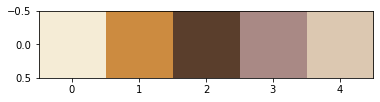

In [9]:
plt.imshow([dfPaleta['paleta_rgb'][0]])
plt.show()




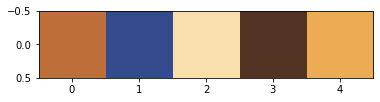

In [12]:
plt.imshow([dfPaleta['paleta_rgb'][86]])
plt.show()


# Testes

In [ ]:
dfList = []
dfList.append(pd.read_json('dataset_artistas/andy-warhol.json', orient='records'))
dfList.append(pd.read_json('dataset_artistas/frida-kahlo.json', orient='records'))
dfList.append(pd.read_json('dataset_artistas/sandro-botticelli.json', orient='records'))
dfList.append(pd.read_json('dataset_artistas/vincent-van-gogh.json', orient='records'))
dfList.append(pd.read_json('dataset_artistas/pablo-picasso.json', orient='records'))

df = pd.concat(dfList, ignore_index=True)
# df.head()


df[df.duplicated(['artistName'], keep=False)]
